In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1
    df = df.resample("1d").mean()
    df.fillna(method="ffill", inplace=True)

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.adjclose.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=9);

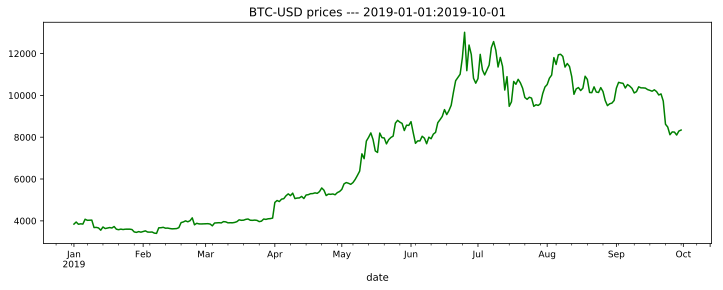

In [24]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2019-01-01', 
                  end_date='2019-10-01', 
                  freq='daily', 
                  path='data/BTC.csv')

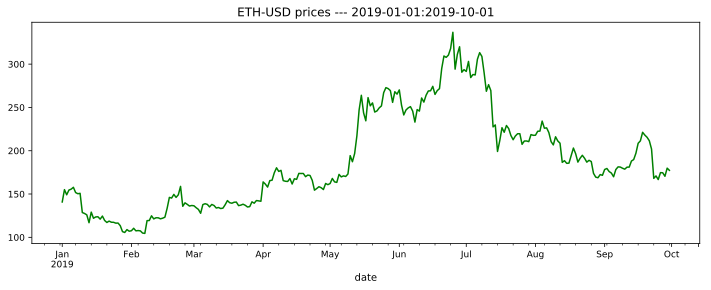

In [25]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2019-01-01', 
                  end_date='2019-10-01', 
                  freq='daily', 
                  path='data/ETH.csv')

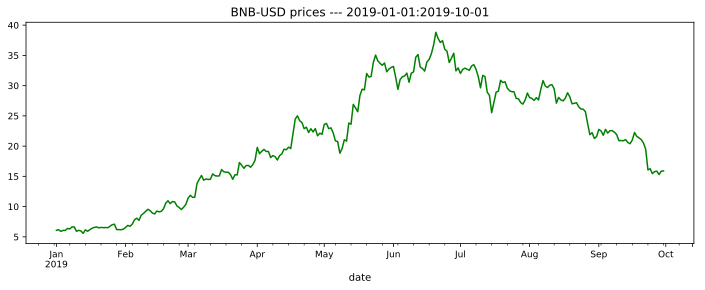

In [26]:
download_csv_data(ticker='BNB-USD', 
                  start_date='2019-01-01', 
                  end_date='2019-10-01', 
                  freq='daily', 
                  path='data/BNB.csv')

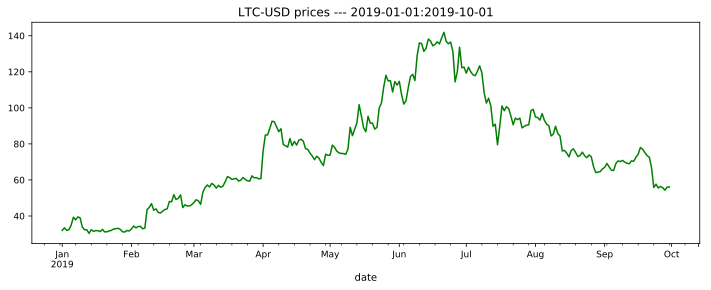

In [27]:
download_csv_data(ticker='LTC-USD', 
                  start_date='2019-01-01', 
                  end_date='2019-10-01', 
                  freq='daily', 
                  path='data/LTC.csv')

In [28]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH', 'BNB', 'LTC']

In [29]:
# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
        
COLUMNS = ['open', 'close']

                   open        close
date                                
2019-01-01  3843.520020  3843.520020
2019-01-02  3943.409424  3943.409424
2019-01-03  3836.741211  3836.741211
2019-01-04  3857.717529  3857.717529
2019-01-05  3845.194580  3845.194580
                  open       close
date                              
2019-01-01  140.819412  140.819412
2019-01-02  155.047684  155.047684
2019-01-03  149.135010  149.135010
2019-01-04  154.581940  154.581940
2019-01-05  155.638596  155.638596
                open     close
date                          
2019-01-01  6.075273  6.075273
2019-01-02  6.188613  6.188613
2019-01-03  5.903534  5.903534
2019-01-04  6.065138  6.065138
2019-01-05  6.065543  6.065543
                 open      close
date                            
2019-01-01  31.979931  31.979931
2019-01-02  33.433681  33.433681
2019-01-03  32.026699  32.026699
2019-01-04  32.404167  32.404167
2019-01-05  34.936867  34.936867


In [30]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 273 (major_axis) x 2 (minor_axis)
Items axis: BTC to LTC
Major_axis axis: 2019-01-01 00:00:00+00:00 to 2019-09-30 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [31]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr(method='pearson')

,BTC,ETH,BNB,LTC
BTC,1.000000,0.806752,0.822942,0.709423
ETH,0.806752,1.000000,0.909251,0.927914
BNB,0.822942,0.909251,1.000000,0.942942
LTC,0.709423,0.927914,0.942942,1.000000


In [32]:
data_corr.corr(method='kendall')

,BTC,ETH,BNB,LTC
BTC,1.000000,0.705398,0.643881,0.571967
ETH,0.705398,1.000000,0.770308,0.765514
BNB,0.643881,0.770308,1.000000,0.809147
LTC,0.571967,0.765514,0.809147,1.000000


In [33]:
data_corr.corr(method='spearman')

,BTC,ETH,BNB,LTC
BTC,1.000000,0.864048,0.823993,0.747424
ETH,0.864048,1.000000,0.933254,0.924598
BNB,0.823993,0.933254,1.000000,0.944863
LTC,0.747424,0.924598,0.944863,1.000000


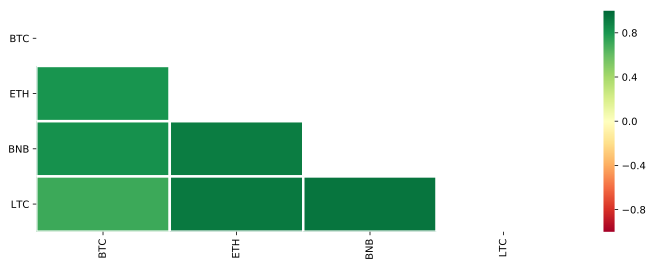

In [40]:
import seaborn
#take the bottom triangle since it repeats itself
mask = np.zeros_like(data_corr.corr())
mask[np.triu_indices_from(mask)] = True
#generate plot
seaborn.heatmap(data_corr.corr(), cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

# Построение границы эффективности

###  Задаем стартовые параметры

In [97]:
# set the number of combinations for imaginary portfolios
COMMISSION = 0
REBALANCE_PERIOD = 10000000000

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

### Определяем стартовые переменные

In [98]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BTC']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2018, 12, 31, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2019, 12, 31, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                #trading_calendar=AlwaysOpenCalendar(),
                                handle_data=handle_data,
                                data=panel)

        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [99]:
qf.get_performance_summary(returns)

annual_volatility     0.688839
annualized_returns    0.863252
cumulative_returns    0.867859
max_drawdown         -0.497572
sharpe_ratio          1.244405
sortino_ratio         1.975084
dtype: float64